# Notebook to compare Model Results in R17 Maritime, UCLA vs UA 

# Step 0 - Prepare Notebook

In [1]:
import os
import time 
import json
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from snowML.datapipe.utils import data_utils as du
from snowML.LSTM import set_hyperparams as sh
from snowML.LSTM import LSTM_pre_process as pp 
from snowML.LSTM import LSTM_train as LSTM_tr
from snowML.LSTM import LSTM_metrics as met
from snowML.LSTM import LSTM_plot3 as plot3
from snowML.Scripts import local_training_mixed_loss as ml


# Step 1 - Define HyperParams and Test Hucs 

In [2]:
# get list of hucs 
f = "../../src/snowML/datapipe/huc_lists/MandM_hucs_.json"
with open(f, 'r', encoding='utf-8') as file:
    data = json.load(file)
hucs_mar = data["maritime_hucs"]
print(f"Number of hcs_mar is {len(hucs_mar)}")


Number of hcs_mar is 154


In [3]:
# error ls 
error_ls = ['171100080201', '171100050602']


In [4]:
hucs_mar_clean = [huc for huc in hucs_mar if huc not in error_ls]
len(hucs_mar_clean)

152

In [5]:
# set hyperparams
# load base line params 
params = sh.create_hyper_dict()
# reset the ones we care about
params["learning_rate"] = .001
params["n_epochs"] = 10    
params["batch_size"] = 32
params["var_list"] = ['mean_pr', 'mean_tair']
params["expirement_name"] = "UA_UCLA_Compare"
params["loss_type"] = "mse"
params["train_size_dimension"] = "time"
params["train_size_fraction"] = .67
params["recursive_rredict"] = False 
params["UCLA"] = False # start w/ UA data then update 
#params

# Step 2 - Define model functions 

In [6]:
def pre_process(huc, params): 
    # normalize the data and create train/test split 
    df_dict = pp.pre_process_separate([huc], params["var_list"], UCLA = params["UCLA"], filter_dates=params["filter_dates"])
    train_size_frac = params["train_size_fraction"]
    df = df_dict[huc]
    df_train, _, _, _ = pp.train_test_split_time(df, train_size_frac)
    return df_dict, df_train

def train_model (df_train, params): 
    model_dawgs, optimizer_dawgs, loss_fn_dawgs = ml.initialize_model(params)
   
    for epoch in range(params["n_epochs"]):
        # for local training, call fine_tune instead of pre_train
        #print(f"Training in epoch {epoch}")
        LSTM_tr.fine_tune(
            model_dawgs,
            optimizer_dawgs,
            loss_fn_dawgs,
            df_train,
            params,
            epoch
            )
    return model_dawgs 

def evaluate(model_dawgs_trained, df_dict, huc, params):
    if params["UCLA"]:
        suffix = "UCLA"
    else: 
        suffix = "UA"
    data, y_tr_pred, y_te_pred, y_tr_true, y_te_true,  y_te_pred_recur, train_size, = LSTM_tr.predict_prep (model_dawgs_trained,
                df_dict, huc, params)
    metric_dict_test = met.calc_metrics(y_te_true, y_te_pred, metric_type = f"test_{suffix}")
    if y_te_pred_recur is not None:
        metric_dict_test_recur = met.calc_metrics(y_te_true, y_te_pred_recur, metric_type = f"test_recur_{suffix}")
        combined_dict = {**metric_dict_test, **metric_dict_test_recur}
    else:
        combined_dict = metric_dict_test
        
    return combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size


def combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size, params):
    results_df = data[["mean_swe"]].copy()
    results_df["y_tr_pred"] = list(y_tr_pred) + [float('nan')] * (len(results_df) - len(y_tr_pred))
    results_df["y_te_pred"] = [float('nan')] * (train_size+params["lookback"]) + list(y_te_pred)
    results_df["y_tr_true"] = list(y_tr_true) + [float('nan')] * (len(results_df) - len(y_tr_true))
    results_df["y_te_true"] = [float('nan')] *(train_size+params["lookback"]) + list(y_te_true)
    return results_df

def label_results(df, suffix):
    df = df.add_suffix(f"_{suffix}")
    return df

def run_one_data_type (huc, params, data_type = "UA"): 
    if data_type == "UCLA": 
        params["UCLA"] = True 
        suffix = "UCLA" 
    else: 
        params["UCLA"] = False
        suffix = "UA"
    df_dict, df_train = pre_process(huc, params)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # ignore warning about drop param being irrelevant with single deep layer
        model_dawgs_trained = train_model(df_train, params)
    combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size = evaluate(model_dawgs_trained, df_dict, huc, params)
    df_results = combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size, params)
    df_results = label_results(df_results, suffix)
    return combined_dict, df_results, tr_size

def run_all(hucs, params, dis = False): 
    #time_start = time.time()
    dict_UA, results_df_UA, tr_size_UA  = run_one_data_type(huc, params)
    dict_UCLA, results_df_UCLA, tr_size_UCLA = run_one_data_type (huc, params, data_type = "UCLA")
    metrics_dict_all = {**dict_UA, **dict_UCLA}
    results_df_all = pd.concat([results_df_UA, results_df_UCLA], axis=1)
    plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size_UA, huc, params, dis = dis)
    #du.elapsed(time_start)
    return metrics_dict_all, results_df_all
       

def plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size, huc, params, dis = False):
    cutoff = tr_size + params["lookback"]
    df_plot = results_df_all.iloc[cutoff:]

    # Prepare data for plots
    plot_dict_UA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UA"], "blue", "SWE Estimates UA Data (Physics Based Model)", n_offset=0)
    plot_dict_UA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UA"], "green", "SWE Predictions UA Data", n_offset=0)

    plot_dict_UCLA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UCLA"], "black", "SWE Estimates UCLA Data (Physics Based Model)", n_offset=0)
    plot_dict_UCLA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UCLA"], "red", "SWE Predictions UCLA Data", n_offset=0)

    x_axis_vals = df_plot.index
    ttl = f"SWE_Actual_vs_Predicted_for_huc_{huc}"

    # Temp file paths
    filenames = [f"plot_{i}.png" for i in range(3)]

    # Plot and save each figure
    plot3.plot3b(x_axis_vals, [plot_dict_UA_true, plot_dict_UA_pred], ttl + "_UA_data", metrics_dict=dict_UA)
    plt.savefig(filenames[0])
    plt.close()

    plot3.plot3b(x_axis_vals, [plot_dict_UCLA_true, plot_dict_UCLA_pred], ttl + "_UCLA_data", metrics_dict=dict_UCLA)
    plt.savefig(filenames[1])
    plt.close()

    plot3.plot3b(x_axis_vals,
                 [plot_dict_UA_true, plot_dict_UA_pred, plot_dict_UCLA_true, plot_dict_UCLA_pred],
                 ttl, metrics_dict=metrics_dict_all)
    plt.savefig(filenames[2])
    plt.close()

    # Combine saved plots vertically
    images = [Image.open(fname) for fname in filenames]
    widths, heights = zip(*(img.size for img in images))

    total_height = sum(heights)
    max_width = max(widths)
    combined_img = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for img in images:
        combined_img.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the final combined image
    output_path = f"charts/SWE_combined_plots_{huc}.png"
    combined_img.save(output_path)
    if dis: 
        display(combined_img)
    
    # Cleanup temporary files
    for fname in filenames:
        os.remove(fname)

    print(f"Saved combined plot to {output_path}")


# Step 3 - Get Results Sample Huc 

In [7]:
huc = 171100050606

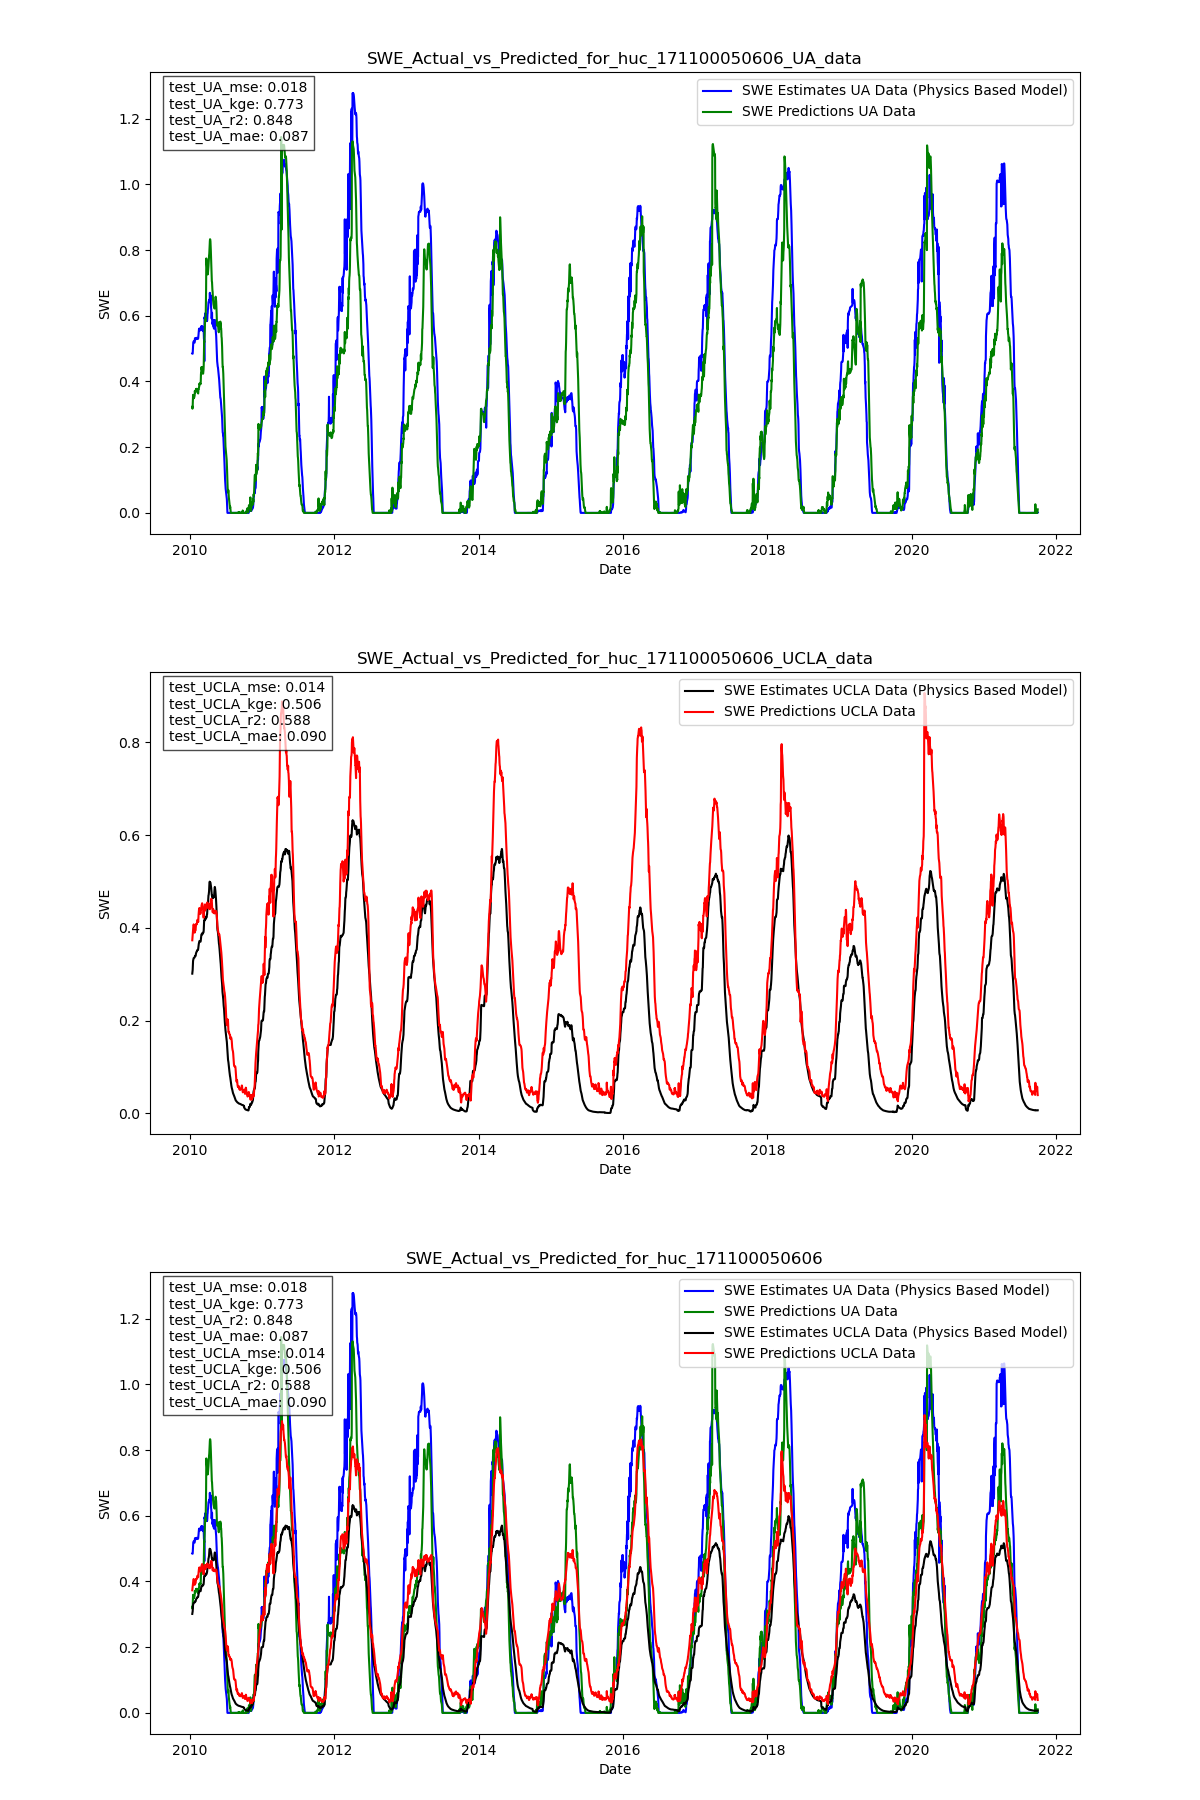

Saved combined plot to charts/SWE_combined_plots_171100050606.png


In [8]:
dict, df = run_all(huc, params, dis = True)

In [9]:
dict

{'test_UA_mse': 0.018061766,
 'test_UA_kge': 0.7733506660771475,
 'test_UA_r2': 0.8482554934011326,
 'test_UA_mae': 0.0870737,
 'test_UCLA_mse': 0.013759755,
 'test_UCLA_kge': 0.5056310591404019,
 'test_UCLA_r2': 0.5877738044640888,
 'test_UCLA_mae': 0.08999978}

In [10]:
df

,mean_swe_UA,y_tr_pred_UA,y_te_pred_UA,y_tr_true_UA,y_te_true_UA,mean_swe_UCLA,y_tr_pred_UCLA,y_te_pred_UCLA,y_tr_true_UCLA,y_te_true_UCLA
day,,,,,,,,,,
1984-10-01,0.000000,[0.5207381],NaN,[0.9314286],NaN,0.000000,[0.4320472],NaN,[0.54418176],NaN
1984-10-02,0.000000,[0.820918],NaN,[0.565],NaN,0.000000,[0.44773397],NaN,[0.5512264],NaN
1984-10-03,0.000000,[0.8243156],NaN,[0.871],NaN,0.000000,[0.4431703],NaN,[0.5540232],NaN
1984-10-04,0.000000,[0.82016486],NaN,[0.9045714],NaN,0.000000,[0.45024377],NaN,[0.55521774],NaN
1984-10-05,0.000000,[0.8193873],NaN,[0.9431429],NaN,0.000036,[0.45790356],NaN,[0.55822414],NaN
...,...,...,...,...,...,...,...,...,...,...
2021-09-26,0.000000,NaN,[-0.00012945592],NaN,[0.0],0.006318,NaN,[0.050523225],NaN,[0.006317995]
2021-09-27,0.000000,NaN,[-6.334573e-05],NaN,[0.0],0.006267,NaN,[0.05754878],NaN,[0.006267426]
2021-09-28,0.000000,NaN,[-2.3268163e-05],NaN,[0.0],0.006501,NaN,[0.052202437],NaN,[0.006501139]


# Step 4 Loop through all the maritime hucs

In [11]:
df_results = None
count = 0

for huc in hucs_mar_clean:    
    count += 1
    print(f"processing huc {count}")
    dict, df = run_all(huc, params)
    f_out = f"model_results_UA_UCLA_huc_{huc}"
    b = "snowml-results"
    du.dat_to_s3(df, b, f_out, file_type="csv")
    new_row = pd.DataFrame([dict])
    new_row["huc"] = huc
    
    if df_results is None:
        df_results = new_row
    else:
        df_results = pd.concat([df_results, new_row], ignore_index=True)

df_results.set_index("huc", inplace=True)
f_out = "metrics_UA_v_UCLA_maritime"
du.dat_to_s3(df_results, b, f_out, file_type="csv")
df_results


processing huc 1
Saved combined plot to charts/SWE_combined_plots_170200090101.png
File model_results_UA_UCLA_huc_170200090101.csv successfully uploaded to snowml-results
processing huc 2
Saved combined plot to charts/SWE_combined_plots_170200090102.png
File model_results_UA_UCLA_huc_170200090102.csv successfully uploaded to snowml-results
processing huc 3
Saved combined plot to charts/SWE_combined_plots_170200090103.png
File model_results_UA_UCLA_huc_170200090103.csv successfully uploaded to snowml-results
processing huc 4
Saved combined plot to charts/SWE_combined_plots_170200090104.png
File model_results_UA_UCLA_huc_170200090104.csv successfully uploaded to snowml-results
processing huc 5
Saved combined plot to charts/SWE_combined_plots_170200090105.png
File model_results_UA_UCLA_huc_170200090105.csv successfully uploaded to snowml-results
processing huc 6
Saved combined plot to charts/SWE_combined_plots_170200090106.png
File model_results_UA_UCLA_huc_170200090106.csv successfully u

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
huc,,,,,,,,
170200090101,0.015019,0.928918,0.912333,0.077274,0.024721,0.659060,0.635900,0.122170
170200090102,0.009633,0.881795,0.941105,0.065177,0.011363,0.744850,0.852330,0.074483
170200090103,0.006073,0.956777,0.952444,0.047646,0.010116,0.774202,0.825367,0.073897
170200090104,0.011961,0.922367,0.933535,0.073813,0.011550,0.818173,0.886278,0.084381
170200090105,0.025661,0.916319,0.890720,0.107907,0.024445,0.729314,0.784465,0.136279
...,...,...,...,...,...,...,...,...
170200100202,0.011817,0.829580,0.889895,0.061540,0.020639,0.228429,0.171947,0.100996
170200100203,0.010278,0.909060,0.907365,0.065537,0.006045,0.838835,0.840724,0.055895
171100070101,0.008782,0.751933,0.721835,0.043429,0.022919,0.399367,0.424629,0.104371


In [12]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.019043,0.783943,0.815855,0.076555,0.039489,0.431412,-0.307135,0.123266
std,0.021240,0.147864,0.123107,0.038862,0.123565,0.589203,7.241018,0.117280
min,0.000522,0.304845,0.340663,0.010622,0.001301,-5.877487,-87.062695,0.020948
25%,0.008038,0.701157,0.760524,0.050570,0.011459,0.345830,0.260839,0.074437
50%,0.013598,0.828307,0.854607,0.070658,0.020766,0.532941,0.553197,0.105902
75%,0.024415,0.900833,0.909076,0.096347,0.033920,0.660504,0.732510,0.139214
max,0.205007,0.972916,0.965165,0.324704,1.373940,0.923185,0.893602,1.153903


In [13]:
df_results["kge_diff"] = df_results["test_UA_kge"] - df_results["test_UCLA_kge"]
df_results

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
170200090101,0.015019,0.928918,0.912333,0.077274,0.024721,0.659060,0.635900,0.122170,0.269858
170200090102,0.009633,0.881795,0.941105,0.065177,0.011363,0.744850,0.852330,0.074483,0.136945
170200090103,0.006073,0.956777,0.952444,0.047646,0.010116,0.774202,0.825367,0.073897,0.182575
170200090104,0.011961,0.922367,0.933535,0.073813,0.011550,0.818173,0.886278,0.084381,0.104194
170200090105,0.025661,0.916319,0.890720,0.107907,0.024445,0.729314,0.784465,0.136279,0.187005
...,...,...,...,...,...,...,...,...,...
170200100202,0.011817,0.829580,0.889895,0.061540,0.020639,0.228429,0.171947,0.100996,0.601151
170200100203,0.010278,0.909060,0.907365,0.065537,0.006045,0.838835,0.840724,0.055895,0.070225
171100070101,0.008782,0.751933,0.721835,0.043429,0.022919,0.399367,0.424629,0.104371,0.352566


In [14]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.019043,0.783943,0.815855,0.076555,0.039489,0.431412,-0.307135,0.123266,0.352531
std,0.021240,0.147864,0.123107,0.038862,0.123565,0.589203,7.241018,0.117280,0.605919
min,0.000522,0.304845,0.340663,0.010622,0.001301,-5.877487,-87.062695,0.020948,-0.226056
25%,0.008038,0.701157,0.760524,0.050570,0.011459,0.345830,0.260839,0.074437,0.125482
50%,0.013598,0.828307,0.854607,0.070658,0.020766,0.532941,0.553197,0.105902,0.270185
75%,0.024415,0.900833,0.909076,0.096347,0.033920,0.660504,0.732510,0.139214,0.456001
max,0.205007,0.972916,0.965165,0.324704,1.373940,0.923185,0.893602,1.153903,6.842874


In [15]:
df_sorted = df_results.sort_values(by="kge_diff", ascending=False)
df_sorted

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
171100050604,0.005278,0.965387,0.941353,0.045025,0.024320,-5.877487,-87.062695,0.107201,6.842874
170200110307,0.003829,0.839685,0.867158,0.030308,0.018694,-0.661084,-1.595747,0.086633,1.500769
170200110305,0.006379,0.793340,0.853122,0.039260,0.029461,-0.375388,-1.086387,0.106853,1.168729
170200110203,0.004001,0.913226,0.880629,0.036670,0.013694,-0.195672,-0.660931,0.081870,1.108898
171100080107,0.012315,0.852109,0.792034,0.060372,0.046049,-0.182500,-0.359114,0.157490,1.034609
...,...,...,...,...,...,...,...,...,...
170300020105,0.011960,0.760728,0.879479,0.063798,0.005604,0.909562,0.838729,0.047112,-0.148833
170300020303,0.007795,0.747467,0.893316,0.055033,0.004724,0.916943,0.875610,0.049222,-0.169475
171100090102,0.043539,0.497442,0.563522,0.115978,0.012102,0.689267,0.814996,0.083507,-0.191825


In [16]:
# with mlflow.start_run():
        #ml.set_ml_server(params)
        # log all the params
        #mlflow.log_params(params)
        # log the hucs & train size fraction
        #mlflow.log_param("hucs", hucs)
        # log the model
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}", pickle_module=cloudpickle)
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}")
            